In [1]:
# Importing Necessary Libraries
import tensorflow
import seaborn
import google
import os
import pandas
import matplotlib
import numpy
import zipfile
import sklearn 
from tqdm.notebook import tqdm
!pip install soundfile
import soundfile
from IPython.display import Audio

In [ ]:
# Kaggle API Authentication
!pip install -q kaggle
google.colab.files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
# Downloading and Unzipping The Dataset
!kaggle datasets download -d vbookshelf/respiratory-sound-database
!unzip -q respiratory-sound-database.zip

100% 3.67G/3.69G [01:11<00:00, 28.0MB/s]
100% 3.69G/3.69G [01:11<00:00, 55.5MB/s]


In [13]:
# Initializing The Patient Data
patient_data = pandas.read_csv("/content/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv", names = ["Patient ID", "Diagnosis"])   
patient_data.head()

,Patient ID,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
def get_file_information(filename):
  return filename.split("_")

In [ ]:
# Initializing Signal Data 
filenames = [filename.split(".")[0] for filename in os.listdir("/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files") if ".txt" in filename]
collected_data = []

for filename in tqdm(filenames):
  data = pandas.read_csv("/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/" + filename + ".txt", sep = "\t", names = ["Start", "End", "Crackles", "Wheezes"])
  file_information = get_file_information(filename)
  data["Patient ID"] = file_information[0]
  data["Audio Type"] = file_information[-2]
  data["Filename"] = filename
  collected_data.append(data)

signal_data = pandas.concat(collected_data)
signal_data.reset_index()
signal_data.head()

,Start,End,Crackles,Wheezes,Patient ID,Audio Type,Filename
0,0.025,3.765,0,0,163,mc,163_2b2_Tc_mc_AKGC417L
1,3.765,8.553,0,0,163,mc,163_2b2_Tc_mc_AKGC417L
2,8.553,13.257,0,0,163,mc,163_2b2_Tc_mc_AKGC417L
3,13.257,17.369,0,0,163,mc,163_2b2_Tc_mc_AKGC417L
4,17.369,19.958,0,0,163,mc,163_2b2_Tc_mc_AKGC417L


In [ ]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  126 non-null    int64 
 1   Diagnosis   126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
signal_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 9
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Start       6898 non-null   float64
 1   End         6898 non-null   float64
 2   Crackles    6898 non-null   int64  
 3   Wheezes     6898 non-null   int64  
 4   Patient ID  6898 non-null   object 
 5   Audio Type  6898 non-null   object 
 6   Filename    6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [ ]:
patient_data["Patient ID"] = patient_data["Patient ID"].astype("int32")
signal_data["Patient ID"] = signal_data["Patient ID"].astype("int32")

In [ ]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  126 non-null    int32 
 1   Diagnosis   126 non-null    object
dtypes: int32(1), object(1)
memory usage: 1.6+ KB


In [ ]:
signal_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 9
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Start       6898 non-null   float64
 1   End         6898 non-null   float64
 2   Crackles    6898 non-null   int64  
 3   Wheezes     6898 non-null   int64  
 4   Patient ID  6898 non-null   int32  
 5   Audio Type  6898 non-null   object 
 6   Filename    6898 non-null   object 
dtypes: float64(2), int32(1), int64(2), object(2)
memory usage: 404.2+ KB


In [ ]:
data = pandas.merge(signal_data, patient_data, on = "Patient ID")
data.head()

,Start,End,Crackles,Wheezes,Patient ID,Audio Type,Filename,Diagnosis
0,0.025,3.765,0,0,163,mc,163_2b2_Tc_mc_AKGC417L,COPD
1,3.765,8.553,0,0,163,mc,163_2b2_Tc_mc_AKGC417L,COPD
2,8.553,13.257,0,0,163,mc,163_2b2_Tc_mc_AKGC417L,COPD
3,13.257,17.369,0,0,163,mc,163_2b2_Tc_mc_AKGC417L,COPD
4,17.369,19.958,0,0,163,mc,163_2b2_Tc_mc_AKGC417L,COPD


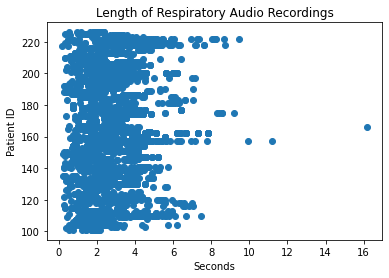

In [ ]:
matplotlib.pyplot.figure()
matplotlib.pyplot.scatter(x = (data["End"] - data["Start"]), y = data["Patient ID"])
matplotlib.pyplot.xlabel("Seconds")
matplotlib.pyplot.ylabel("Patient ID")
matplotlib.pyplot.title("Length of Respiratory Audio Recordings")
matplotlib.pyplot.show()

In [ ]:
def get_pure_audio_sample(raw_data, start, end, sample_rate):
  max_index = len(raw_data)
  start_index = min(int(start * sample_rate), max_index)
  end_index = min(int(end * sample_rate), max_index)
  return raw_data[start_index: end_index]

In [ ]:
os.mkdir("Processed_Audio_Files")

In [ ]:
for index, row in tqdm(data.iterrows()):
  max_length = 6
  start = row["Start"]
  end = row["End"]
  filename = row["Filename"]

  if end - start > max_length:
    end = start + max_length
  
   audio_file_path = "/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/" + filename + ".wav" 

  if index > 0:
    if data.iloc[index - 1]["Filename"] == filename:
      i += 1 
    else:   
      i = 0

  filename = filename + "_" + str(i) + ".wav"

  save_path = "/content/Processed_Audio_Files/" + filename

  audio, sample_rate = librosa.load(audio_file_path)
  pure_audio = get_pure_audio_sample(raw_audio, start, end, sample_rate) 

  required_length = (sample_rate * 6) 
  padded_audio = librosa.util.pad_center(pure_audio,  required_length)

  soundfile.write(file = save_path, data = padded_audio, samplerate = sample_rate)

In [ ]:
# Downloading Processed Audio Files
with zipfile.ZipFile("/content/drive/MyDrive/Processed_Audio_Files.zip", "r") as zip_ref:
    zip_ref.extractall("/content/Processed_Audio_Files")

In [14]:
def get_patient_id(filename):
  return filename.split("_")[0]

In [15]:
path = "/content/Processed_Audio_Files"
length = len(os.listdir(path))
index = range(length)
i = 0 

files = pandas.DataFrame(index = index, columns = ["Patient ID", "Filename"])

for filename in tqdm(os.listdir(path)):
  files.iloc[i]["Patient ID"] = get_patient_id(filename)
  files.iloc[i]["Filename"] = filename
  i += 1

files.head()

,Patient ID,Filename
0,205,205_4b2_Lr_mc_AKGC417L_0.wav
1,154,154_4b4_Lr_mc_AKGC417L_3.wav
2,163,163_8b3_Ll_mc_AKGC417L_4.wav
3,149,149_1b1_Pl_sc_Meditron_13.wav
4,198,198_6p1_Ll_mc_AKGC417L_4.wav


In [ ]:
files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6898 entries, 0 to 6897
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  6898 non-null   object
 1   Filename    6898 non-null   object
dtypes: object(2)
memory usage: 107.9+ KB


In [ ]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  126 non-null    int32 
 1   Diagnosis   126 non-null    object
dtypes: int32(1), object(1)
memory usage: 1.6+ KB


In [16]:
files["Patient ID"] = files["Patient ID"].astype("int32")
patient_data["Patient ID"] = patient_data["Patient ID"].astype("int32")

In [ ]:
files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6898 entries, 0 to 6897
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  6898 non-null   int32 
 1   Filename    6898 non-null   object
dtypes: int32(1), object(1)
memory usage: 81.0+ KB


In [ ]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  126 non-null    int32 
 1   Diagnosis   126 non-null    object
dtypes: int32(1), object(1)
memory usage: 1.6+ KB


In [17]:
data = pandas.merge(files, patient_data, on = "Patient ID")
data.head()

,Patient ID,Filename,Diagnosis
0,205,205_4b2_Lr_mc_AKGC417L_0.wav,COPD
1,205,205_4b2_Pr_mc_AKGC417L_4.wav,COPD
2,205,205_1b3_Ll_mc_AKGC417L_2.wav,COPD
3,205,205_1b3_Pl_mc_AKGC417L_5.wav,COPD
4,205,205_4b2_Al_mc_AKGC417L_2.wav,COPD


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, data["Diagnosis"], stratify = data["Diagnosis"], test_size = 0.1)

In [ ]:
import librosa
from librosa import display

Visualizing MFCC's From All Eight Classes

In [ ]:
def visualize_mfcc(filename, label):
  filename = "/content/Processed_Audio_Files/" + filename
  audio, sample_rate = librosa.load(filename)
  mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
  matplotlib.pyplot.figure(figsize = (10, 4))
  img = display.specshow(mfcc, x_axis = "time", y_axis = "mel")
  matplotlib.pyplot.colorbar(format='%+2.0f dB')
  matplotlib.pyplot.title(label)

In [ ]:
asthma = []
for index, row in tqdm(X_train.iterrows()):
  if row["Diagnosis"] == "Asthma":
    asthma.append(row["Filename"])

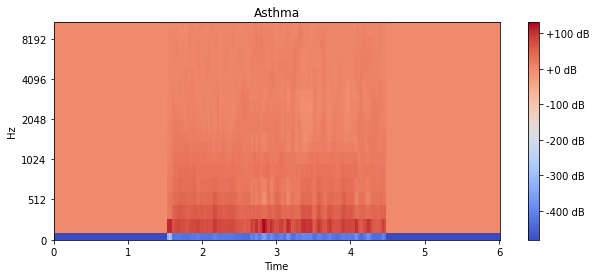

In [ ]:
visualize_mfcc(filename = asthma[0], label = "Asthma")

In [ ]:
bronchiectasis = []
for index, row in tqdm(X_train.iterrows()):
  if row["Diagnosis"] == "Bronchiectasis":
    bronchiectasis.append(row["Filename"])

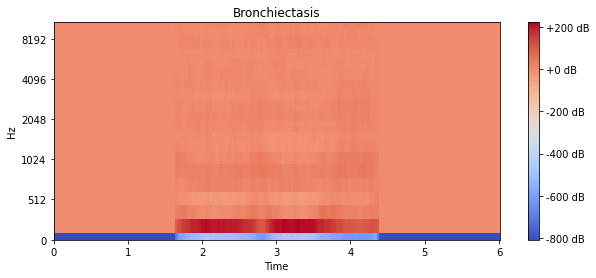

In [ ]:
visualize_mfcc(filename = bronchiectasis[0], label = "Bronchiectasis")

In [ ]:
bronchiolitis = []
for index, row in tqdm(X_train.iterrows()):
  if row["Diagnosis"] == "Bronchiolitis":
    bronchiolitis.append(row["Filename"])

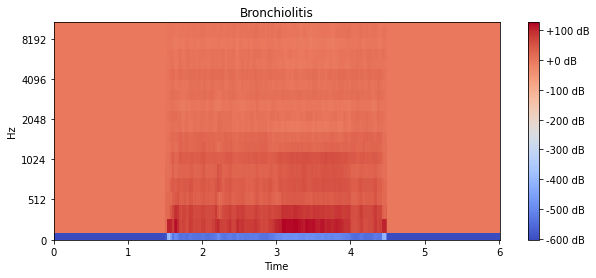

In [ ]:
visualize_mfcc(filename = bronchiolitis[0], label = "Bronchiolitis")

In [ ]:
copd = []
for index, row in tqdm(X_train.iterrows()):
  if row["Diagnosis"] == "COPD":
    copd.append(row["Filename"])

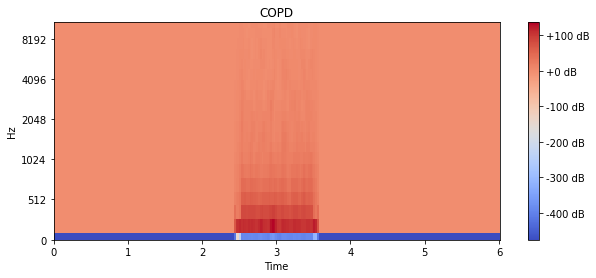

In [ ]:
visualize_mfcc(filename = copd[0], label = "COPD")

In [ ]:
healthy = []
for index, row in tqdm(X_train.iterrows()):
  if row["Diagnosis"] == "Healthy":
    healthy.append(row["Filename"])

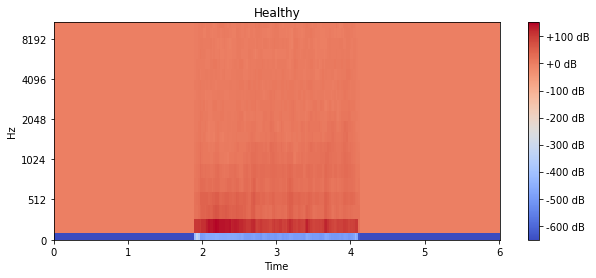

In [ ]:
visualize_mfcc(filename = healthy[0], label = "Healthy")

In [ ]:
lrti = []
for index, row in tqdm(X_train.iterrows()):
  if row["Diagnosis"] == "LRTI":
    lrti.append(row["Filename"])

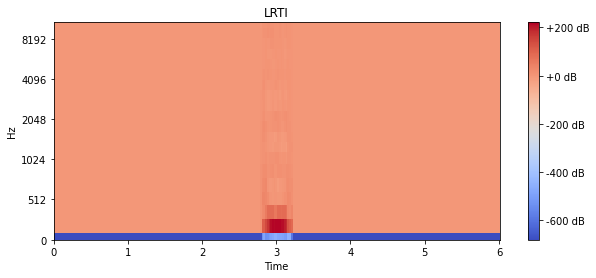

In [ ]:
visualize_mfcc(filename = lrti[0], label = "LRTI")

In [ ]:
pneumonia = [] 
for index, row in tqdm(X_train.iterrows()):
  if row["Diagnosis"] == "Pneumonia":
    pneumonia.append(row["Filename"])

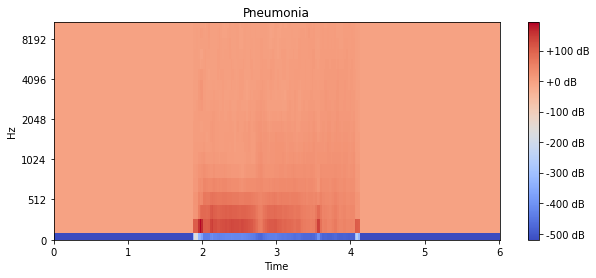

In [ ]:
visualize_mfcc(filename = pneumonia[0], label = "Pneumonia")

In [ ]:
urti = []
for index, row in tqdm(X_train.iterrows()):
  if row["Diagnosis"] == "URTI":
    urti.append(row["Filename"])

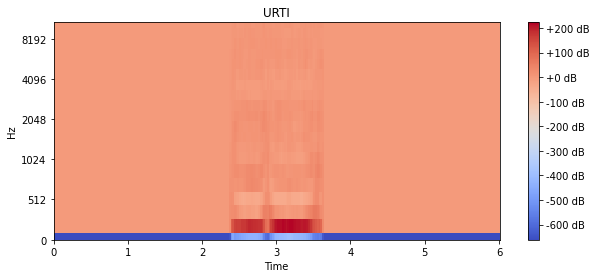

In [ ]:
visualize_mfcc(filename = urti[0], label = "URTI")

Visualizing Mel-Spectrograms From All Eight Classes

In [ ]:
def visualize_mel_spectrogram(filename, label):
  filename = "/content/Processed_Audio_Files/" + filename
  audio, sample_rate = librosa.load(filename)
  mel_spectrogram = librosa.feature.melspectrogram(y = audio, sr = sample_rate)
  matplotlib.pyplot.figure(figsize = (10, 4))
  display.specshow(librosa.power_to_db(mel_spectrogram), y_axis = "mel", x_axis = "time")
  matplotlib.pyplot.colorbar(format='%+2.0f dB')
  matplotlib.pyplot.title(label)

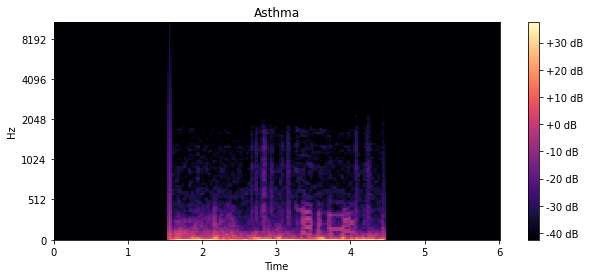

In [ ]:
visualize_mel_spectrogram(filename = asthma[0], label = "Asthma")

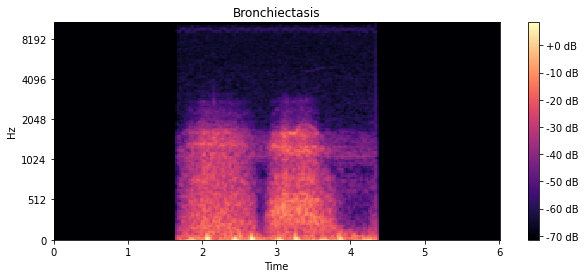

In [ ]:
visualize_mel_spectrogram(filename = bronchiectasis[0], label = "Bronchiectasis")

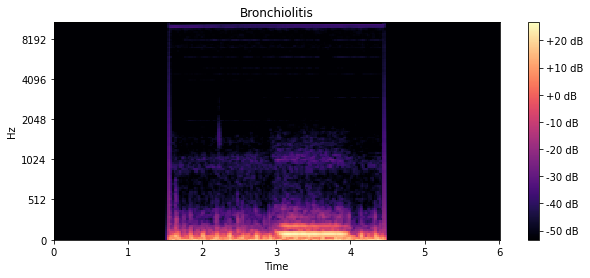

In [ ]:
visualize_mel_spectrogram(filename = bronchiolitis[0], label = "Bronchiolitis")

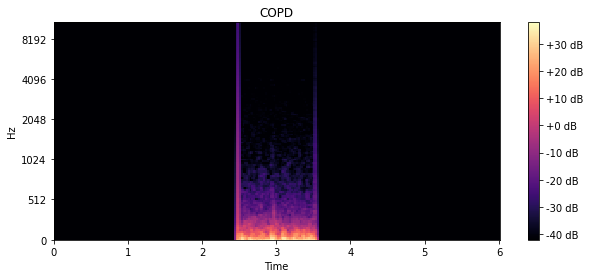

In [ ]:
visualize_mel_spectrogram(filename = copd[0], label = "COPD")

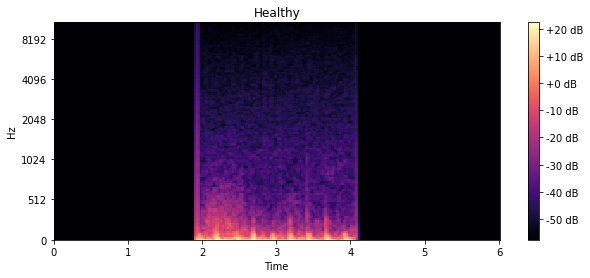

In [ ]:
visualize_mel_spectrogram(filename = healthy[0], label = "Healthy")

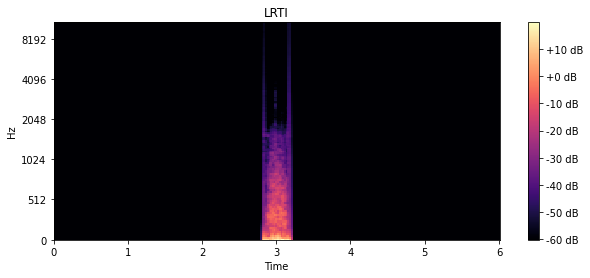

In [ ]:
visualize_mel_spectrogram(filename = lrti[0], label = "LRTI")

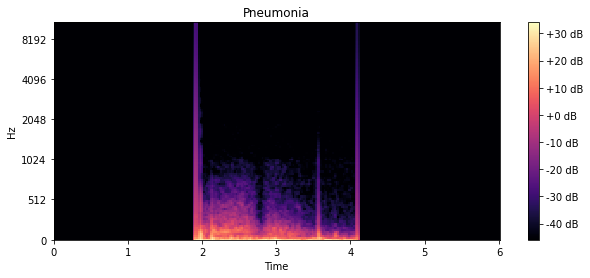

In [ ]:
visualize_mel_spectrogram(filename = pneumonia[0], label = "Pneumonia")

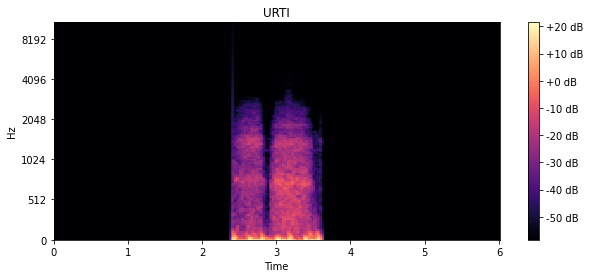

In [ ]:
visualize_mel_spectrogram(filename = urti[0], label = "URTI")

In [ ]:
os.mkdir("/content/Mel_Spectrograms")

In [ ]:
os.mkdir("/content/Mel_Spectrograms/Asthma")
os.mkdir("/content/Mel_Spectrograms/Bronchiectasis")
os.mkdir("/content/Mel_Spectrograms/Bronchiolitis")
os.mkdir("/content/Mel_Spectrograms/COPD")
os.mkdir("/content/Mel_Spectrograms/Healthy")
os.mkdir("/content/Mel_Spectrograms/LRTI")
os.mkdir("/content/Mel_Spectrograms/Pneumonia")
os.mkdir("/content/Mel_Spectrograms/URTI")

In [ ]:
for index, row in tqdm(X_train.iterrows()):
  filename = "/content/Processed_Audio_Files/" + row["Filename"]
  audio, sample_rate = librosa.load(filename)
  mel_spectrogram = librosa.feature.melspectrogram(y = audio, sr = sample_rate)
  matplotlib.pyplot.figure(figsize = (10, 4))
  display.specshow(librosa.power_to_db(mel_spectrogram))
  matplotlib.pyplot.savefig("/content/Mel_Spectrograms/" + row["Diagnosis"] + "/" + "".join(list(row["Filename"])[:-4]) + ".png", bbox_inches = "tight", pad_inches = 0)
  matplotlib.pyplot.close()

In [ ]:
os.mkdir("/content/MFCC")

In [ ]:
os.mkdir("/content/MFCC/Asthma")
os.mkdir("/content/MFCC/Bronchiectasis")
os.mkdir("/content/MFCC/Bronchiolitis")
os.mkdir("/content/MFCC/COPD")
os.mkdir("/content/MFCC/Healthy")
os.mkdir("/content/MFCC/LRTI")
os.mkdir("/content/MFCC/Pneumonia")
os.mkdir("/content/MFCC/URTI")

In [ ]:
for index, row in tqdm(X_train.iterrows()):
  filename = "/content/Processed_Audio_Files/" + row["Filename"]
  audio, sample_rate = librosa.load(filename) 
  mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
  matplotlib.pyplot.figure(figsize = (10, 4))
  display.specshow(mfcc) 
  matplotlib.pyplot.savefig("/content/MFCC/" + row["Diagnosis"] + "/" + "".join(list(row["Filename"])[:-4]) + ".png", bbox_inches = "tight", pad_inches = 0)
  matplotlib.pyplot.close() 

In [3]:
image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
                  rescale = 1./255
)
training_image_generator = image_generator.flow_from_directory(directory = "/content/MFCC", target_size = (561, 220))

Found 6208 images belonging to 8 classes.


In [4]:
mobilenet = tensorflow.keras.applications.mobilenet.MobileNet(input_shape = (561, 220, 3), include_top = False)
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561, 220, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 281, 110, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 281, 110, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 281, 110, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 281, 110, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 281, 110, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 281, 110, 32

In [5]:
# Specializing MobileNet for Respiratory Dataset
x = mobilenet.output
x = tensorflow.keras.layers.Flatten()(x)
x = tensorflow.keras.layers.Dense(units = 256, activation = "relu")(x)
x = tensorflow.keras.layers.Dense(units = 256, activation = "relu")(x)
predictions = tensorflow.keras.layers.Dense(units = 8, activation = "softmax")(x)

model = tensorflow.keras.models.Model(inputs = mobilenet.input, outputs = predictions)

In [6]:
for layer in tqdm(model.layers[:-26]):
  layer.trainable = False

In [7]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [8]:
model.fit(training_image_generator, epochs = 50, callbacks = tensorflow.keras.callbacks.EarlyStopping(monitor = "loss", patience = 3, mode = "min", restore_best_weights = True))

Epoch 1/50
194/194 [==============================] - 39s 158ms/step - loss: 4.8398 - accuracy: 0.7792
Epoch 2/50
194/194 [==============================] - 29s 147ms/step - loss: 0.3546 - accuracy: 0.8727
Epoch 3/50
194/194 [==============================] - 28s 146ms/step - loss: 0.2768 - accuracy: 0.9001
Epoch 4/50
194/194 [==============================] - 29s 148ms/step - loss: 0.2065 - accuracy: 0.9279
Epoch 5/50
194/194 [==============================] - 28s 145ms/step - loss: 0.1683 - accuracy: 0.9342
Epoch 6/50
194/194 [==============================] - 29s 149ms/step - loss: 0.1431 - accuracy: 0.9495
Epoch 7/50
194/194 [==============================] - 28s 146ms/step - loss: 0.1419 - accuracy: 0.9493
Epoch 8/50
194/194 [==============================] - 28s 145ms/step - loss: 0.1147 - accuracy: 0.9575
Epoch 9/50
194/194 [==============================] - 29s 147ms/step - loss: 0.0959 - accuracy: 0.9623
Epoch 10/50
194/194 [==============================] - 28s 145ms/step - l

In [9]:
os.mkdir("/content/MFCC_Test")

In [11]:
os.mkdir("/content/MFCC_Test/Asthma")
os.mkdir("/content/MFCC_Test/Bronchiectasis")
os.mkdir("/content/MFCC_Test/Bronchiolitis")
os.mkdir("/content/MFCC_Test/COPD")
os.mkdir("/content/MFCC_Test/Healthy")
os.mkdir("/content/MFCC_Test/LRTI")
os.mkdir("/content/MFCC_Test/Pneumonia")
os.mkdir("/content/MFCC_Test/URTI")

In [21]:
for index, row in tqdm(X_test.iterrows()):
  filename = "/content/Processed_Audio_Files/" + row["Filename"]
  audio, sample_rate = librosa.load(filename) 
  mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
  matplotlib.pyplot.figure(figsize = (10, 4))
  display.specshow(mfcc) 
  matplotlib.pyplot.savefig("/content/MFCC_Test/" + row["Diagnosis"] + "/" + "".join(list(row["Filename"])[:-4]) + ".png", bbox_inches = "tight", pad_inches = 0)
  matplotlib.pyplot.close() 

In [22]:
testing_image_generator = image_generator.flow_from_directory(directory = "/content/MFCC_Test", target_size = (561, 220))

Found 690 images belonging to 8 classes.


In [23]:
print("Testing Accuracy: {}".format(model.evaluate(testing_image_generator)[1] * 100))

22/22 [==============================] - 4s 145ms/step - loss: 0.0880 - accuracy: 0.9812
Testing Accuracy: 98.11594486236572


In [24]:
model.save("RESPIRATORY_RESNET50_FINAL.h5")

In [25]:
os.mkdir("/content/MFCC_Unique_Test")

In [26]:
os.mkdir("/content/MFCC_Unique_Test/Asthma")
os.mkdir("/content/MFCC_Unique_Test/Bronchiectasis")
os.mkdir("/content/MFCC_Unique_Test/Bronchiolitis")
os.mkdir("/content/MFCC_Unique_Test/COPD")
os.mkdir("/content/MFCC_Unique_Test/Healthy")
os.mkdir("/content/MFCC_Unique_Test/LRTI")
os.mkdir("/content/MFCC_Unique_Test/Pneumonia")
os.mkdir("/content/MFCC_Unique_Test/URTI")

In [27]:
for index, row in tqdm(X_test.iterrows()):
  if row["Diagnosis"] != "COPD":
    filename = "/content/Processed_Audio_Files/" + row["Filename"]
    audio, sample_rate = librosa.load(filename)
    mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
    display.specshow(mfcc)
    matplotlib.pyplot.savefig("/content/MFCC_Unique_Test/" + row["Diagnosis"] + "/" + "".join(list(row["Filename"])[:-4]) + ".png", bbox_inches = "tight", pad_inches = 0)
    matplotlib.pyplot.close()

In [28]:
unique_testing_image_generator = image_generator.flow_from_directory(directory = "/content/MFCC_Unique_Test", target_size = (561, 220))

Found 115 images belonging to 8 classes.


In [29]:
print("Unique Testing Accuracy: {}".format(model.evaluate(unique_testing_image_generator)[1] * 100))

4/4 [==============================] - 1s 136ms/step - loss: 0.3755 - accuracy: 0.9391
Unique Testing Accuracy: 93.9130425453186


In [ ]:
import time
time.sleep(2000)